In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from sklearn.model_selection import train_test_split
import json

/home/giles/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/giles/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
train_df = pd.read_csv(PATH/MASKS_FN, index_col="id", usecols=[0])
depths_df = pd.read_csv(PATH/META_FN, index_col="id")

In [6]:
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [9]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [10]:
(PATH/'train-128').mkdir(exist_ok=True)

In [11]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [12]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [13]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [14]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

## Validation split

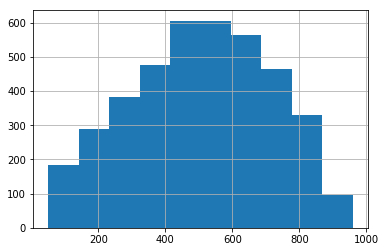

In [15]:
train_df['z'].hist()

In [16]:
train_df['depth_bin'] = 0
for d in range(1,5):
    train_df.loc[train_df.z >= 200*d, 'depth_bin'] = d

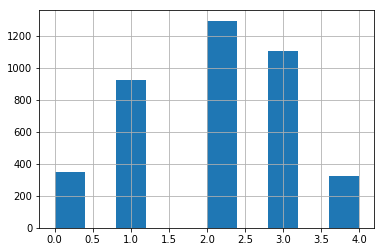

In [17]:
train_df['depth_bin'].hist()

In [18]:
trainIds = [x[x.rfind('/')+1:x.rfind('.')] for x in x_names]

In [19]:
len(x_names), len(train_df)

(4000, 4000)

In [20]:
print(trainIds[0:10])
train_df = train_df.reindex(trainIds)

['d2b40a2781', '89dba191b1', 'e6ac2a35cd', '236a5cc090', 'f30e47cb36', 'e0bde1cf11', 'ad16edc8be', 'fa92bed2b1', '6d46f994ac', 'eabed5b2b4']


In [21]:
train_df.head()

,z,depth_bin
id,,
d2b40a2781,587,2
89dba191b1,567,2
e6ac2a35cd,506,2
236a5cc090,676,3
f30e47cb36,368,1


In [22]:
train_df["masks"] = [np.array(Image.open(f"{PATH}/{MASKS_DN}/{idx}.png")) / 255 for idx in tqdm_notebook(train_df.index)]

In [23]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(101, 2)

In [24]:
train_df["coverage"]

id
d2b40a2781    250.374081
89dba191b1    274.862268
e6ac2a35cd    398.588080
236a5cc090     83.592393
f30e47cb36      0.000000
e0bde1cf11      0.000000
ad16edc8be     18.895206
fa92bed2b1      0.000000
6d46f994ac      0.000000
eabed5b2b4      0.000000
1cad8c327b      0.000000
2fe4adfd48      0.000000
24d67576d0      0.000000
60b3d0d613      0.000000
c32752c00f    159.752671
0ab5e14937      0.000000
6738d474a3      0.000000
9d98768f19     18.391334
b5893fc541     90.319086
e337021e6a      0.000000
7f0bdb5e31    210.013920
ff9b7d0d2e    138.312910
25bd98aec3     12.168513
24bf79cd1e    240.674542
d66e51d456      0.000000
dae1555fbf    357.648466
9a71e8563b      0.000000
eb4efc4c39      0.000000
657f2c34f7    106.820900
0ce8a6ae62     91.931477
                 ...    
670d9655d5    321.067346
9a3abd0ba6    267.052250
ec5afeae66      0.000000
b9614348f4    210.139888
0bca43f7ff    321.319282
d71e91efc0     12.747966
33820f50d8      0.000000
84e305da04    322.075091
be4db8ff8a      0.0000

In [25]:
def cov_to_class(val):    
    for i in range(0, 6):
        print(val)
        if val/100 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

250.37408097245367
250.37408097245367
250.37408097245367
250.37408097245367
274.86226840505833
274.86226840505833
274.86226840505833
274.86226840505833
398.58807960003924
398.58807960003924
398.58807960003924
398.58807960003924
398.58807960003924
83.5923929026566
83.5923929026566
0.0
0.0
18.8952063523184
18.8952063523184
0.0
0.0
0.0
0.0
0.0
0.0
0.0
159.75267130673464
159.75267130673464
159.75267130673464
0.0
0.0
18.39133418292324
18.39133418292324
90.31908636408195
90.31908636408195
0.0
210.0139202039016
210.0139202039016
210.0139202039016
210.0139202039016
138.3129104989707
138.3129104989707
138.3129104989707
12.16851289089305
12.16851289089305
240.6745417115969
240.6745417115969
240.6745417115969
240.6745417115969
0.0
357.6484658366827
357.6484658366827
357.6484658366827
357.6484658366827
357.6484658366827
0.0
0.0
106.82089991177335
106.82089991177335
106.82089991177335
91.93147730614646
91.93147730614646
291.41446916968926
291.41446916968926
291.41446916968926
291.41446916968926
91.

38.39505930791099
0.0
6.122046858151162
6.122046858151162
46.12949710812666
46.12949710812666
385.7645328889325
385.7645328889325
385.7645328889325
385.7645328889325
385.7645328889325
0.0
0.0
0.0
193.15939613763356
193.15939613763356
193.15939613763356
181.39398098225664
181.39398098225664
181.39398098225664
0.0
67.16616018037448
67.16616018037448
231.00019605920988
231.00019605920988
231.00019605920988
231.00019605920988
197.03921184197628
197.03921184197628
197.03921184197628
0.0
228.178511910597
228.178511910597
228.178511910597
228.178511910597
0.0
269.7227722772277
269.7227722772277
269.7227722772277
269.7227722772277
0.0
0.0
61.97627683560435
61.97627683560435
44.920203901578276
44.920203901578276
198.72718360945007
198.72718360945007
198.72718360945007
0.0
122.46613077149298
122.46613077149298
122.46613077149298
0.0
185.4753455543574
185.4753455543574
185.4753455543574
315.09646113126166
315.09646113126166
315.09646113126166
315.09646113126166
315.09646113126166
0.0
279.69944123

0.0
206.537202235075
206.537202235075
206.537202235075
206.537202235075
0.0
0.0
0.7306146456229782
0.7306146456229782
236.59317713949613
236.59317713949613
236.59317713949613
236.59317713949613
168.4948534457406
168.4948534457406
168.4948534457406
1.8391334182923242
1.8391334182923242
0.0
399.16753259484364
399.16753259484364
399.16753259484364
399.16753259484364
399.16753259484364
0.0
0.0
0.0
1.0077443387903147
1.0077443387903147
0.0
0.0
8.716988530536222
8.716988530536222
343.03617292422314
343.03617292422314
343.03617292422314
343.03617292422314
343.03617292422314
0.0
170.45995490638174
170.45995490638174
170.45995490638174
361.42750710714637
361.42750710714637
361.42750710714637
361.42750710714637
361.42750710714637
0.0
167.26036663072247
167.26036663072247
167.26036663072247
0.0
0.0
0.0
302.575237721792
302.575237721792
302.575237721792
302.575237721792
302.575237721792
8.112341927262033
8.112341927262033
35.6993432016469
35.6993432016469
15.871973335947455
15.871973335947455
0.0


In [26]:
set(train_df["coverage_class"])

{0, 1, 2, 3, 4, 5}

/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Coverage class')

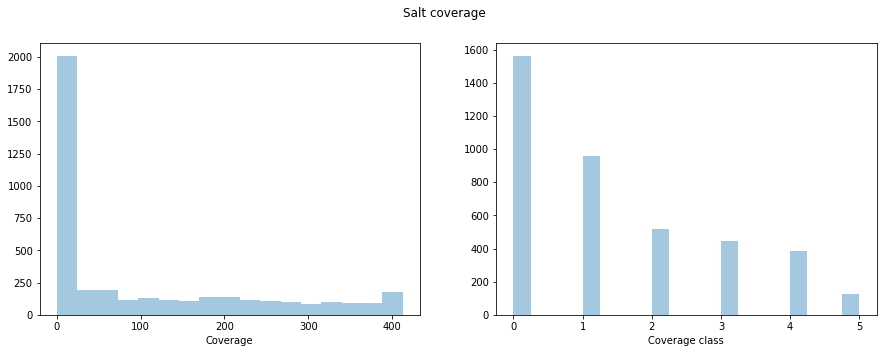

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [28]:
train_df['strat'] = 0
train_df.loc[train_df.depth_bin < train_df.coverage_class,  'strat'] = np.square(train_df.loc[train_df.depth_bin < train_df.coverage_class, 'depth_bin']) + train_df.loc[train_df.depth_bin < train_df.coverage_class, 'coverage_class']
train_df.loc[train_df.depth_bin >= train_df.coverage_class,  'strat'] = np.square(train_df.loc[train_df.depth_bin >= train_df.coverage_class, 'coverage_class']) + train_df.loc[train_df.depth_bin >= train_df.coverage_class, 'coverage_class'] + train_df.loc[train_df.depth_bin >= train_df.coverage_class, 'depth_bin']

In [29]:
set(train_df['strat']), len(set(train_df['depth_bin']))*len(set(train_df['coverage_class']))

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 21, 24}, 30)

In [30]:
idxs = train_test_split(range(len(train_df)), test_size=0.2, stratify=train_df['strat'])
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(idxs[1], x_names, y_names)

In [31]:
val_y

array(['/home/giles/Downloads/fastai_data/salt/train_masks-128/89dba191b1.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/e6ac2a35cd.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/ad16edc8be.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/1cad8c327b.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/d66e51d456.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/921b60e76d.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/7eb42fe5ec.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/badb3ea766.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/7fc1ce1cb4.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/499560e566.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/2b76b47947.png',
       '/home/giles/Downloads/fastai_data/salt/train_masks-128/39400e0443.png',
       '/home/giles/Downloads/fastai_dat

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe93223b438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe93223b438>)

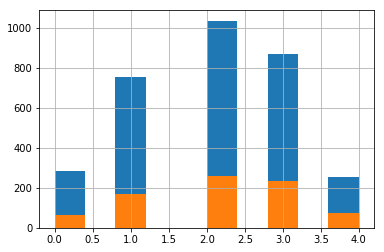

In [32]:
train_df['depth_bin'].iloc[idxs[0]].hist(), train_df['depth_bin'].iloc[idxs[1]].hist()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe932399cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe932399cc0>)

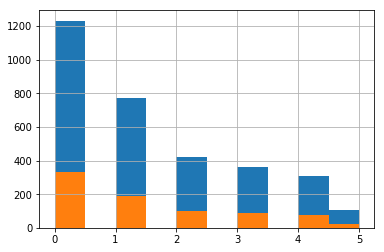

In [33]:
train_df['coverage_class'].iloc[idxs[0]].hist(), train_df['coverage_class'].iloc[idxs[1]].hist()

### Data prep

In [34]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [35]:
tfms = tfms_from_model(resnet34, 128, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [36]:
x,y = next(iter(md.trn_dl))

In [37]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

In [38]:
denorm = md.val_ds.denorm

In [39]:
def show_aug_img(ims, idx, figsize=(5,5), normed=True, ax=None, nchannels=3):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,nchannels+1)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [45]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

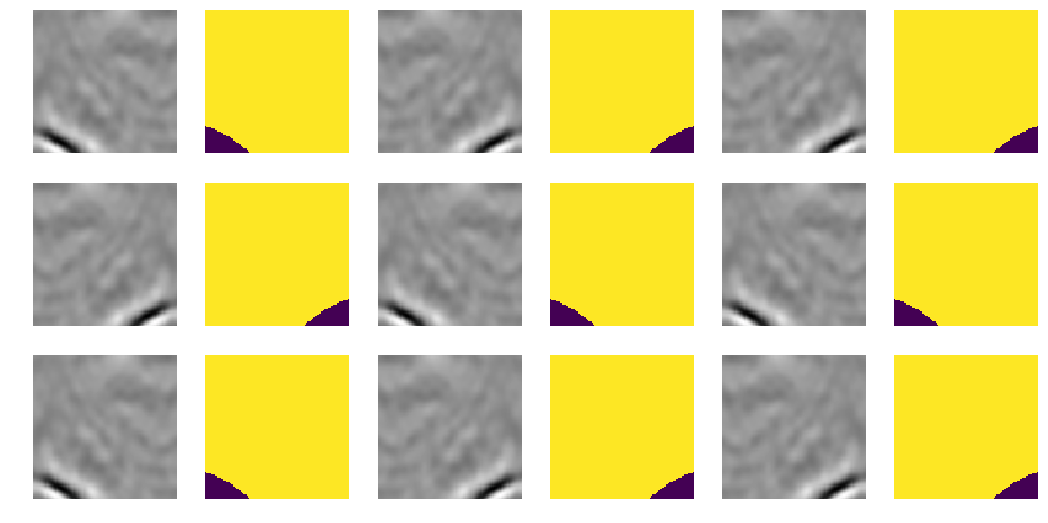

In [47]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

## Simple upsample

In [48]:
f = resnet34
cut,lr_cut = model_meta[f]

In [49]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [50]:
def dice(pred, targs):
    pred = (pred>0.5).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [51]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [52]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [53]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [54]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

## Training loop

In [51]:
def trainModel(uid, models, trn_x, trn_y, val_x,val_y, aug_tfms, lr=2e-2, wd=1e-7, bs=64):
    ##32
    print('Running on 32x32')
    sz = 32
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    denorm = md.trn_ds.denorm
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    
    learn.freeze_to(1)
    lrs = np.array([lr/9,lr/3,lr])
    learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/2, 1, wds=wd, cycle_len=20,use_clr=(20,10), best_save_name='tmp')
    
    ##64
    print('Running on 64x64')
    sz = 64
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1,wds=wd, cycle_len=10,use_clr=(10,10), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    
    ##128
    print('Running on 128x128')
    sz = 128
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1, wds=wd, cycle_len=6,use_clr=(6,4), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/5,1, wds=wd,cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    learn.load('tmp')
    learn.fit(lrs/5,5, wds=wd,cycle_len=1,cycle_mult=2, best_save_name='model_'+str(uid))

In [52]:
from sklearn.model_selection import KFold

In [53]:
nSplits = 10

In [54]:
kf = KFold(n_splits=nSplits, shuffle=True)
folds = kf.split(trn_x)
for i, (train, test) in enumerate(folds):
    print('_____________________________')
    print('Running fold', i+1,'/', nSplits)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    trainModel(i, models, trn_x[train], trn_y[train], trn_x[test], trn_y[test], aug_tfms)
    print('_____________________________')

_____________________________
Running fold 1 / 10
Running on 32x32


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.332972   0.277103   0.781192   0.896832  
    1      0.277615   0.22802    0.789781   0.907794       
    2      0.239645   0.192648   0.817324   0.91994        
    3      0.223564   0.205      0.76781    0.905551       
    4      0.200377   0.184066   0.837341   0.925659       
    5      0.182582   0.183376   0.811919   0.920148       
    6      0.164461   0.171711   0.831611   0.926907       
    7      0.149261   0.165771   0.849568   0.932428       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.192779   0.200854   0.798965   0.915079  
    1      0.200854   0.24199    0.799193   0.906418       
    2      0.222298   0.27145    0.668353   0.8763         
    3      0.240558   0.212868   0.819302   0.91973        
    4      0.213217   0.209823   0.830699   0.921869       
    5      0.18959    0.169071   0.841019   0.926797       
    6      0.168297   0.169625   0.852126   0.929797       
    7      0.1486     0.164925   0.84718    0.931573       
    8      0.135421   0.187616   0.818756   0.92179        
    9      0.130673   0.143994   0.857775   0.937122       
    10     0.115178   0.181248   0.83516    0.924368       
    11     0.109404   0.168261   0.835387   0.928839       
    12     0.098013   0.141291   0.881099   0.944223        
    13     0.088379   0.131973   0.888625   0.947888        
    14     0.081702   0.141094   0.870971   0.941718        
    15     0.074956   0.136785   0.88738  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.250956   0.152494   0.869332   0.940169  
    1      0.195321   0.136641   0.867814   0.94098        
    2      0.173583   0.166903   0.816533   0.921365       
    3      0.160318   0.134994   0.888192   0.94736        
    4      0.145909   0.12027    0.877016   0.944625       
    5      0.130296   0.128594   0.892912   0.950658       
    6      0.124394   0.125417   0.885149   0.94793        
    7      0.1164     0.119714   0.885629   0.947861       
    8      0.107275   0.134149   0.881286   0.945797       
    9      0.096723   0.120378   0.887384   0.948027        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.128809   0.134049   0.868505   0.940979  
    1      0.152193   0.162206   0.868335   0.938685       
    2      0.130902   0.124756   0.898413   0.952009       
    3      0.117397   0.108279   0.912714   0.959393       
    4      0.100391   0.102132   0.912832   0.958871        
    5      0.091891   0.105639   0.915711   0.96067         
    6      0.0775     0.098707   0.912657   0.959608        
    7      0.071906   0.102937   0.912536   0.959627        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.208268   0.183073   0.870986   0.939784  
    1      0.190063   0.166684   0.867234   0.937267       
    2      0.172376   0.147463   0.874879   0.941442       
    3      0.155436   0.132811   0.879663   0.944845       
    4      0.141294   0.123435   0.904244   0.95431        
    5      0.133781   0.139547   0.86398    0.939961       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.133573   0.12269    0.898783   0.951876  
    1      0.139335   0.116148   0.907401   0.956022       
    2      0.127505   0.112846   0.913612   0.95894        
    3      0.111953   0.11104    0.900812   0.954387       
    4      0.104187   0.09155    0.922594   0.962884       
    5      0.093701   0.089937   0.925539   0.964127        
    6      0.082055   0.093429   0.917307   0.960941        
    7      0.072735   0.089557   0.924868   0.964232        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.097665   0.102695   0.91621    0.960223  
    1      0.105818   0.107261   0.900888   0.954205        
    2      0.092601   0.09348    0.920937   0.9623          
    3      0.093898   0.124506   0.903355   0.955097        
    4      0.100224   0.108337   0.906982   0.955682        
    5      0.088473   0.092109   0.928141   0.964913        
    6      0.076993   0.090652   0.924765   0.963853        
    7      0.087602   0.15132    0.884244   0.948573        
    8      0.091357   0.149919   0.886998   0.947708        
    9      0.095697   0.10192    0.920094   0.962035        
    10     0.081789   0.086612   0.929688   0.966622        
    11     0.06752    0.088021   0.923986   0.963725        
    12     0.059633   0.086423   0.926985   0.965143        
    13     0.053252   0.081952   0.93399    0.968585        
    14     0.051523   0.082104   0.933705   0.968445        
    15     0.054737   0.224215

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.342241   0.395877   0.742568   0.863715  
    1      0.28152    0.256232   0.740047   0.896042       
    2      0.252928   0.227835   0.780234   0.907971       
    3      0.231911   0.21727    0.791915   0.912851       
    4      0.209026   0.209534   0.792634   0.914792       
    5      0.190403   0.191564   0.81574    0.922833       
    6      0.171407   0.222229   0.830164   0.921591       
    7      0.157956   0.197648   0.832224   0.927618       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.192197   0.239213   0.670013   0.881131  
    1      0.215197   0.276862   0.728998   0.886469       
    2      0.20701    0.206426   0.805848   0.916486       
    3      0.204601   0.220087   0.805133   0.91524        
    4      0.19047    0.214836   0.77419    0.909222       
    5      0.169747   0.195952   0.797039   0.916248       
    6      0.152487   0.2003     0.833271   0.925739       
    7      0.140618   0.174211   0.835747   0.927954       
    8      0.133437   0.203989   0.809941   0.916675       
    9      0.129862   0.178931   0.837148   0.929431       
    10     0.11645    0.183307   0.843414   0.929691       
    11     0.10392    0.196964   0.862513   0.937207       
    12     0.091989   0.175294   0.861856   0.937238        
    13     0.082698   0.197442   0.856229   0.936804        
    14     0.075515   0.186463   0.857801   0.937006        
    15     0.069467   0.201741   0.86425  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.244992   0.199584   0.765645   0.909249  
    1      0.195073   0.156693   0.846584   0.933557       
    2      0.172647   0.148974   0.866356   0.940946       
    3      0.155749   0.145441   0.855998   0.93805        
    4      0.142658   0.145737   0.872164   0.941657       
    5      0.127899   0.136777   0.879604   0.945258       
    6      0.119893   0.141243   0.875162   0.944475       
    7      0.109746   0.151727   0.867714   0.940427       
    8      0.101981   0.146576   0.872315   0.941924       
    9      0.093213   0.137487   0.883014   0.946485        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.119088   0.19179    0.848374   0.932368  
    1      0.140099   0.147695   0.86902    0.941666       
    2      0.118224   0.147156   0.867782   0.940736       
    3      0.099964   0.135886   0.889906   0.948833        
    4      0.08267    0.126307   0.899243   0.953181        
    5      0.073695   0.139979   0.896347   0.951371        
    6      0.063506   0.143327   0.898338   0.952607        
    7      0.057524   0.141188   0.900808   0.953964        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.191267   0.188284   0.840498   0.929309  
    1      0.183822   0.163067   0.847843   0.934755       
    2      0.161712   0.148694   0.884691   0.946738       
    3      0.149066   0.145074   0.88878    0.949009       
    4      0.135795   0.157855   0.859304   0.9392         
    5      0.121617   0.139377   0.888838   0.949438       



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.111799   0.198175   0.858405   0.939192  
    1      0.120963   0.147998   0.877595   0.944574       
    2      0.112182   0.141518   0.886058   0.949055       
    3      0.100574   0.138116   0.895037   0.950027        
    4      0.089318   0.139566   0.892      0.949335        
    5      0.080607   0.129571   0.900509   0.954078        
    6      0.071091   0.131944   0.897772   0.952663        
    7      0.062879   0.132918   0.897879   0.951692        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.0906     0.132072   0.890556   0.949339  
    1      0.091019   0.13266    0.89359    0.949668        
    2      0.073083   0.129005   0.89976    0.953569        
    3      0.080562   0.172364   0.873461   0.939812        
    4      0.078061   0.14123    0.894474   0.951672        
    5      0.067214   0.131182   0.901817   0.955113        
    6      0.058221   0.132034   0.899949   0.953738        
    7      0.066163   0.169351   0.871313   0.940247        
    8      0.089246   0.147451   0.882863   0.945856        
    9      0.090344   0.134271   0.87937    0.945336        
    10     0.078504   0.125489   0.903005   0.953429        
    11     0.068024   0.118381   0.909341   0.957475        
    12     0.05764    0.118499   0.907521   0.95755         
    13     0.051542   0.116807   0.909857   0.958442        
    14     0.048381   0.117577   0.908617   0.957658        
    15     0.059451   0.157191

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.327568   0.409131   0.712356   0.885818  
    1      0.277486   0.252971   0.71453    0.891037       
    2      0.250764   0.224441   0.79431    0.910361       
    3      0.221884   0.197877   0.803549   0.92002        
    4      0.205744   0.212954   0.82519    0.922406       
    5      0.190235   0.183891   0.820782   0.924704       
    6      0.169043   0.187944   0.823096   0.926163       
    7      0.157864   0.204831   0.816198   0.923889       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.230533   0.215936   0.824112   0.922086  
    1      0.226949   0.219102   0.753735   0.903864       
    2      0.237286   0.211987   0.81322    0.919885       
    3      0.22127    0.214211   0.805841   0.917407       
    4      0.202697   0.185897   0.845657   0.931506       
    5      0.19096    0.195546   0.821983   0.923563       
    6      0.17034    0.172209   0.838204   0.932224       
    7      0.156025   0.157983   0.830673   0.929318       
    8      0.159947   0.190903   0.831969   0.928571       
    9      0.144322   0.184261   0.846978   0.928711       
    10     0.136879   0.165359   0.853303   0.938419       
    11     0.117657   0.166721   0.849955   0.93602        
    12     0.106072   0.176365   0.854665   0.935648       
    13     0.09209    0.176176   0.870737   0.941571        
    14     0.082916   0.181311   0.859996   0.937534        
    15     0.076792   0.184377   0.856151  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.252369   0.197094   0.829089   0.928693  
    1      0.199886   0.190048   0.850647   0.932241       
    2      0.178133   0.172827   0.851883   0.9357         
    3      0.159776   0.169249   0.863692   0.942213       
    4      0.148247   0.154887   0.871498   0.942768       
    5      0.142401   0.156573   0.871476   0.945201       
    6      0.129011   0.141413   0.879803   0.946989       
    7      0.119836   0.141783   0.871907   0.943607       
    8      0.110706   0.142689   0.879433   0.947124       
    9      0.099044   0.153381   0.881604   0.946664        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.116616   0.145546   0.877965   0.945908  
    1      0.124107   0.146398   0.86388    0.942236       
    2      0.116421   0.139612   0.878054   0.946927       
    3      0.101205   0.144459   0.883931   0.946914       
    4      0.091647   0.128604   0.902155   0.954702        
    5      0.079159   0.160866   0.893586   0.952248        
    6      0.070361   0.155244   0.890917   0.950919        
    7      0.063713   0.15186    0.889446   0.950288        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.198437   0.179684   0.826003   0.928004  
    1      0.195529   0.205919   0.841666   0.923956       
    2      0.182703   0.157951   0.851548   0.937733       
    3      0.15932    0.158731   0.859575   0.940228       
    4      0.144962   0.142894   0.883244   0.948148       
    5      0.131569   0.137611   0.880051   0.946751       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.128019   0.144952   0.868088   0.94442   
    1      0.137918   0.15033    0.892213   0.949026       
    2      0.127889   0.131796   0.887612   0.951373       
    3      0.114199   0.121178   0.897733   0.954534       
    4      0.109543   0.128601   0.868271   0.943618       
    5      0.100235   0.108876   0.902159   0.955827       
    6      0.087126   0.116604   0.904235   0.957503        
    7      0.077178   0.114076   0.908238   0.959077        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.094924   0.115782   0.900653   0.956159  
    1      0.107218   0.13706    0.884374   0.949101        
    2      0.090224   0.121512   0.898727   0.95525         
    3      0.108373   0.164593   0.829415   0.931686        
    4      0.108549   0.105038   0.909994   0.959663       
    5      0.088692   0.10642    0.914674   0.961452        
    6      0.073519   0.108321   0.910387   0.960255        
    7      0.077629   0.144703   0.878269   0.946371        
    8      0.092347   0.134619   0.902879   0.95636         
    9      0.085442   0.143463   0.890632   0.952769        
    10     0.078045   0.126705   0.905298   0.957946        
    11     0.068689   0.115646   0.908549   0.95757         
    12     0.061862   0.120269   0.905438   0.95715         
    13     0.056172   0.120343   0.907845   0.959006        
    14     0.053063   0.118601   0.908478   0.958761        
    15     0.060338   0.170511 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.326726   0.954866   0.626105   0.816357  
    1      0.272578   0.263651   0.739107   0.888651       
    2      0.24386    0.235703   0.779192   0.898334       
    3      0.217907   0.239397   0.770273   0.89791        
    4      0.201769   0.241446   0.749761   0.891107       
    5      0.181095   0.229384   0.813598   0.909933       
    6      0.164381   0.224873   0.798889   0.907532       
    7      0.147007   0.218398   0.829296   0.916577       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.177853   0.305041   0.687289   0.867856  
    1      0.217227   0.223538   0.817864   0.912061       
    2      0.225551   0.258588   0.767418   0.896521       
    3      0.209608   0.253964   0.787392   0.902448       
    4      0.18293    0.268697   0.781742   0.900946       
    5      0.164027   0.239877   0.832627   0.918027       
    6      0.144451   0.208283   0.828089   0.914838       
    7      0.139693   0.234001   0.813228   0.911325       
    8      0.122474   0.236443   0.825923   0.910733       
    9      0.118479   0.255738   0.806294   0.909335       
    10     0.103983   0.219708   0.849792   0.92446        
    11     0.093721   0.246848   0.849087   0.923474        
    12     0.087782   0.265896   0.822702   0.914001        
    13     0.080131   0.244669   0.855326   0.926437        
    14     0.074176   0.273867   0.839145   0.920856        
    15     0.069406   0.285025   0.848734

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.34579    0.215072   0.804652   0.909118  
    1      0.229514   0.202642   0.826799   0.917899       
    2      0.184552   0.180369   0.857912   0.927452       
    3      0.163759   0.176025   0.819418   0.915566       
    4      0.146462   0.167674   0.843913   0.924168       
    5      0.137225   0.173622   0.823496   0.916496       
    6      0.126845   0.169163   0.849501   0.924899       
    7      0.118379   0.186438   0.833169   0.919562       
    8      0.106857   0.182464   0.840487   0.921503       
    9      0.098745   0.178668   0.857462   0.927357        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.143781   0.16937    0.823956   0.918138  
    1      0.159464   0.214203   0.768486   0.897154       
    2      0.142346   0.171198   0.849913   0.927158       
    3      0.126669   0.174571   0.843154   0.923743       
    4      0.110233   0.195605   0.83845    0.922556       
    5      0.092234   0.205842   0.850333   0.926318        
    6      0.080854   0.198465   0.86411    0.932527        
    7      0.070654   0.217567   0.857291   0.929634        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.187818   0.212848   0.815987   0.915927  
    1      0.172481   0.169712   0.84085    0.925217       
    2      0.167363   0.175162   0.844814   0.926012       
    3      0.151509   0.166883   0.862948   0.93174        
    4      0.140566   0.161324   0.873578   0.93597        
    5      0.128395   0.161229   0.856599   0.930267       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.132264   0.182127   0.831421   0.922176  
    1      0.13132    0.175234   0.864001   0.932754       
    2      0.128161   0.217691   0.808981   0.910852       
    3      0.117684   0.171457   0.849632   0.926376       
    4      0.103018   0.170534   0.862519   0.933711       
    5      0.098289   0.168414   0.873403   0.937726        
    6      0.08548    0.165851   0.878157   0.939238        
    7      0.076132   0.169202   0.887597   0.943326        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.092952   0.197518   0.860123   0.930744  
    1      0.095068   0.173044   0.862407   0.932057        
    2      0.082116   0.200151   0.860662   0.930866        
    3      0.086201   0.160014   0.882893   0.940595        
    4      0.08823    0.198741   0.843076   0.922168        
    5      0.077116   0.198239   0.8614     0.932071        
    6      0.064211   0.201968   0.869554   0.935915        
    7      0.089679   0.197129   0.84281    0.923412        
    8      0.098115   0.176438   0.864011   0.933218        
    9      0.090729   0.226804   0.872884   0.934995        
    10     0.07536    0.238428   0.859657   0.931017        
    11     0.063382   0.205252   0.875289   0.93588         
    12     0.056558   0.214397   0.873732   0.93594         
    13     0.052319   0.216867   0.871924   0.93599         
    14     0.049837   0.214924   0.874526   0.937113        
    15     0.054963   0.175066

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.328945   0.436085   0.668613   0.872531  
    1      0.276618   0.466805   0.508321   0.838046       
    2      0.24736    0.305383   0.622404   0.86506        
    3      0.224776   0.23309    0.77395    0.905243       
    4      0.202779   0.261134   0.757186   0.902139       
    5      0.186687   0.247393   0.747581   0.899408       
    6      0.172044   0.299988   0.785578   0.888885       
    7      0.156122   0.230592   0.811188   0.91582        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.206137   0.338971   0.646675   0.861102  
    1      0.268048   0.257339   0.720582   0.889948       
    2      0.245456   0.367887   0.412039   0.818484       
    3      0.233973   0.222582   0.793483   0.910977       
    4      0.203225   0.217028   0.81566    0.917465       
    5      0.179396   0.209616   0.801524   0.912231       
    6      0.161359   0.212063   0.817246   0.919409       
    7      0.142505   0.219048   0.806183   0.914447       
    8      0.132138   0.228863   0.817863   0.916144       
    9      0.123789   0.227014   0.805885   0.915472       
    10     0.117161   0.273549   0.795215   0.912244       
    11     0.107489   0.242315   0.831328   0.925641       
    12     0.096821   0.219353   0.835175   0.92392         
    13     0.091164   0.258858   0.823191   0.918515        
    14     0.083646   0.244927   0.831618   0.925528        
    15     0.075955   0.213485   0.84673  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.292548   0.193889   0.827356   0.92651   
    1      0.211774   0.199514   0.809061   0.921131       
    2      0.177308   0.192932   0.831408   0.92828        
    3      0.161711   0.168479   0.862393   0.935994       
    4      0.146234   0.163215   0.865417   0.938169       
    5      0.134266   0.169031   0.858944   0.935393       
    6      0.123197   0.16381    0.862804   0.939143       
    7      0.116893   0.155402   0.859599   0.938512       
    8      0.107583   0.175706   0.864068   0.934737       
    9      0.099471   0.162193   0.864394   0.939993        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.143892   0.159847   0.867784   0.939816  
    1      0.14017    0.184669   0.846459   0.930527       
    2      0.139139   0.160336   0.858488   0.939069       
    3      0.119507   0.166816   0.867549   0.941729       
    4      0.103435   0.155628   0.872136   0.941624       
    5      0.090292   0.162441   0.872207   0.940124        
    6      0.079308   0.162816   0.874896   0.943046        
    7      0.070621   0.171416   0.873402   0.941642        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.191881   0.185715   0.84292    0.929303  
    1      0.181658   0.202785   0.793199   0.916239       
    2      0.170224   0.18873    0.852789   0.930274       
    3      0.160567   0.189364   0.815921   0.924183       
    4      0.146183   0.187629   0.859212   0.937179       
    5      0.13148    0.166751   0.864884   0.939054       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.131304   0.182034   0.852267   0.931206  
    1      0.134678   0.155835   0.871361   0.940169       
    2      0.126739   0.15833    0.865349   0.939552       
    3      0.113843   0.159343   0.861845   0.938322       
    4      0.105567   0.156797   0.870478   0.939222       
    5      0.096626   0.141978   0.873775   0.942004        
    6      0.085892   0.154238   0.874812   0.943188        
    7      0.07737    0.16258    0.870673   0.941566        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.100639   0.151691   0.879723   0.944311  
    1      0.098313   0.170634   0.848869   0.933918        
    2      0.087605   0.155112   0.875938   0.944264        
    3      0.095733   0.155569   0.865459   0.937509        
    4      0.09009    0.139267   0.884596   0.94591         
    5      0.077525   0.154385   0.891155   0.949882        
    6      0.067206   0.147764   0.887663   0.947953        
    7      0.081042   0.192116   0.850857   0.934847        
    8      0.110422   0.170286   0.864766   0.940058        
    9      0.102858   0.142301   0.874885   0.944113       
    10     0.084132   0.17626    0.878934   0.945091        
    11     0.072008   0.164094   0.875858   0.944035        
    12     0.063166   0.165695   0.873842   0.943009        
    13     0.055958   0.163217   0.873255   0.942771        
    14     0.053521   0.163318   0.873004   0.942672        
    15     0.05432    0.174498 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.336619   0.28831    0.738784   0.892664  
    1      0.272935   0.23775    0.731109   0.897134       
    2      0.240282   0.238431   0.800917   0.911194       
    3      0.217441   0.218296   0.806158   0.914551       
    4      0.196174   0.234098   0.821687   0.914944       
    5      0.182367   0.236188   0.817381   0.911661       
    6      0.159767   0.225461   0.814726   0.922751       
    7      0.140793   0.204316   0.82198    0.921915       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.190582   0.248296   0.787836   0.911533  
    1      0.202507   0.246845   0.727591   0.895694       
    2      0.19637    0.23882    0.805352   0.910306       
    3      0.190002   0.209442   0.807728   0.917258       
    4      0.173848   0.19991    0.83168    0.925626       
    5      0.152017   0.194726   0.842247   0.93212        
    6      0.147208   0.184774   0.819168   0.924506       
    7      0.139531   0.232664   0.778674   0.906866       
    8      0.138683   0.197643   0.834371   0.927646       
    9      0.127348   0.195805   0.837995   0.926706       
    10     0.116685   0.182187   0.846044   0.930923       
    11     0.102517   0.190571   0.843246   0.932239       
    12     0.08811    0.18635    0.857167   0.936557        
    13     0.081522   0.176828   0.853196   0.936078        
    14     0.074656   0.181055   0.858684   0.936954        
    15     0.068658   0.190386   0.865372 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.241203   0.198258   0.830944   0.928415  
    1      0.20352    0.184917   0.846133   0.929272       
    2      0.174762   0.174827   0.846019   0.934895       
    3      0.159129   0.145104   0.865812   0.941432       
    4      0.144383   0.137743   0.873347   0.944492       
    5      0.128411   0.139424   0.875421   0.94416        
    6      0.116701   0.143169   0.877133   0.945577       
    7      0.108762   0.130837   0.894186   0.950945       
    8      0.102901   0.146571   0.867809   0.942545       
    9      0.0938     0.127989   0.888575   0.95017         



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.119453   0.164273   0.871766   0.938141  
    1      0.128413   0.184639   0.865161   0.937913       
    2      0.114823   0.137825   0.895083   0.9511         
    3      0.099034   0.120977   0.904691   0.95546         
    4      0.084711   0.115445   0.895998   0.953404        
    5      0.076162   0.125541   0.902943   0.953648        
    6      0.066496   0.127724   0.896615   0.951653        
    7      0.059374   0.131064   0.897899   0.954202        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.201487   0.196678   0.831423   0.923508  
    1      0.191461   0.202531   0.816397   0.921883       
    2      0.176172   0.175144   0.835475   0.92909        
    3      0.164668   0.151348   0.863985   0.940321       
    4      0.148127   0.142724   0.87742    0.946953       
    5      0.131435   0.131644   0.879947   0.947448       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.123992   0.165664   0.868904   0.936854  
    1      0.133748   0.122113   0.89016    0.95057        
    2      0.121616   0.133041   0.877793   0.94505        
    3      0.105402   0.121462   0.912616   0.958657       
    4      0.1011     0.143145   0.89716    0.952487       
    5      0.092902   0.127508   0.893868   0.952382        
    6      0.082156   0.128333   0.900151   0.95482         
    7      0.073685   0.121163   0.901625   0.955851        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.100521   0.120633   0.887633   0.94937   
    1      0.110668   0.121738   0.887155   0.950047       
    2      0.093118   0.126599   0.894952   0.952445        
    3      0.094261   0.148587   0.877681   0.946288        
    4      0.089443   0.12496    0.898067   0.952996        
    5      0.078779   0.116964   0.91035    0.959404        
    6      0.067796   0.116416   0.912469   0.960531        
    7      0.075165   0.119852   0.898011   0.953324        
    8      0.080773   0.169218   0.875405   0.940344        
    9      0.102207   0.118949   0.895342   0.952727        
    10     0.09845    0.116675   0.899386   0.953302        
    11     0.081529   0.12597    0.900323   0.954187        
    12     0.067965   0.118058   0.906978   0.957679        
    13     0.058291   0.120388   0.908333   0.958686        
    14     0.053855   0.120261   0.907813   0.958321        
    15     0.066054   0.189013  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.325136   0.583672   0.540017   0.833145  
    1      0.274495   0.258806   0.741975   0.887497       
    2      0.247993   0.27338    0.737401   0.886673       
    3      0.229767   0.227674   0.784675   0.903574       
    4      0.206643   0.252938   0.77577    0.898193       
    5      0.188133   0.215308   0.837027   0.91933        
    6      0.169922   0.206138   0.819602   0.914709       
    7      0.155883   0.211352   0.829216   0.91839        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.194713   0.238718   0.785303   0.900452  
    1      0.214797   0.228928   0.796179   0.909039       
    2      0.206019   0.219392   0.800571   0.908481       
    3      0.205425   0.219216   0.832663   0.918192       
    4      0.185242   0.210167   0.7954     0.907123       
    5      0.158957   0.198401   0.860454   0.930557       
    6      0.138257   0.190885   0.850986   0.92886        
    7      0.142099   0.199937   0.8331     0.920279       
    8      0.129022   0.194452   0.849401   0.927048       
    9      0.12058    0.183968   0.841004   0.925641       
    10     0.117574   0.21839    0.836253   0.92283        
    11     0.114215   0.2028     0.833237   0.922229       
    12     0.100112   0.211825   0.816594   0.917578       
    13     0.09769    0.220136   0.858861   0.928534        
    14     0.087013   0.200294   0.847471   0.929138        
    15     0.076732   0.193899   0.869077  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.270153   0.223627   0.814081   0.914459  
    1      0.204484   0.203503   0.853582   0.927402       
    2      0.171292   0.180178   0.838067   0.926353       
    3      0.149821   0.178056   0.855162   0.931308       
    4      0.142461   0.180553   0.833106   0.924397       
    5      0.127994   0.171398   0.863722   0.935423       
    6      0.116895   0.173324   0.859982   0.934624       
    7      0.106649   0.201407   0.841076   0.927599       
    8      0.097186   0.194537   0.853551   0.933121        
    9      0.089626   0.185265   0.863405   0.936343        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.125995   0.185259   0.853194   0.930782  
    1      0.127784   0.174693   0.861217   0.93308        
    2      0.118864   0.177016   0.854927   0.930376       
    3      0.106681   0.168849   0.862838   0.93651        
    4      0.090754   0.175032   0.878572   0.943432        
    5      0.078518   0.170378   0.880614   0.942198        
    6      0.068209   0.18213    0.872255   0.939376        
    7      0.061061   0.177328   0.880466   0.942922        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.211113   0.195977   0.848051   0.925682  
    1      0.182129   0.217632   0.843951   0.921817       
    2      0.162862   0.17765    0.840705   0.927825       
    3      0.147927   0.17135    0.867863   0.937535       
    4      0.133482   0.175377   0.875473   0.937931       
    5      0.123066   0.162242   0.874124   0.939569       



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.125579   0.175328   0.848472   0.929758  
    1      0.132426   0.185808   0.868188   0.93542        
    2      0.126036   0.160627   0.878515   0.943024       
    3      0.108764   0.157937   0.883907   0.944237       
    4      0.103848   0.163813   0.879541   0.943638       
    5      0.092991   0.15707    0.886327   0.945296        
    6      0.078483   0.164633   0.882536   0.94371         
    7      0.069526   0.159919   0.896175   0.949172        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.08766    0.160025   0.884782   0.944614  
    1      0.095091   0.163601   0.872832   0.940425        
    2      0.079928   0.170468   0.887421   0.945915        
    3      0.086185   0.162434   0.88451    0.945181        
    4      0.084586   0.167974   0.869631   0.939216        
    5      0.070096   0.15982    0.888266   0.9454          
    6      0.060084   0.163644   0.885354   0.94409         
    7      0.070109   0.168075   0.86234    0.935117        
    8      0.090134   0.150147   0.884547   0.94548         
    9      0.090146   0.170918   0.860815   0.935863        
    10     0.075432   0.148823   0.895791   0.949779        
    11     0.063088   0.154258   0.898797   0.950795        
    12     0.056136   0.154494   0.895835   0.949591        
    13     0.050248   0.15617    0.898291   0.950509        
    14     0.047039   0.157147   0.898258   0.950542        
    15     0.052962   0.146971

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.334702   0.281412   0.765802   0.901935  
    1      0.274007   0.216593   0.80544    0.91366        
    2      0.242573   0.20311    0.821102   0.918344       
    3      0.21871    0.20476    0.794344   0.911954       
    4      0.20489    0.189271   0.834463   0.923904       
    5      0.183674   0.187661   0.805754   0.917148       
    6      0.162487   0.167484   0.857487   0.933475       
    7      0.152882   0.181803   0.852099   0.932477       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.207633   0.187688   0.81414    0.918967  
    1      0.285361   0.252454   0.745947   0.895163       
    2      0.262765   0.213838   0.804773   0.915433       
    3      0.238719   0.212773   0.832757   0.923633       
    4      0.213495   0.184328   0.831926   0.926724       
    5      0.197893   0.196176   0.835915   0.923633       
    6      0.176487   0.167532   0.871475   0.940466       
    7      0.168695   0.182991   0.849742   0.929584       
    8      0.150887   0.179319   0.842631   0.929822       
    9      0.137582   0.167838   0.867609   0.938223       
    10     0.124361   0.194752   0.86193    0.934543       
    11     0.112103   0.179567   0.864104   0.937787       
    12     0.123766   0.20854    0.836171   0.925885       
    13     0.115306   0.199819   0.861935   0.934625       
    14     0.103633   0.174948   0.862608   0.938022       
    15     0.08967    0.172163   0.875934   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.248996   0.196134   0.849348   0.928778  
    1      0.199254   0.165769   0.85243    0.933317       
    2      0.177796   0.164243   0.866828   0.937199       
    3      0.162425   0.146343   0.872313   0.942063       
    4      0.150654   0.14056    0.884635   0.947086       
    5      0.138901   0.140988   0.88415    0.947113       
    6      0.127586   0.143848   0.884287   0.946388       
    7      0.119203   0.168624   0.865887   0.936137       
    8      0.109806   0.150054   0.888845   0.948209       
    9      0.099226   0.151655   0.888089   0.948055        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.131753   0.165732   0.859406   0.934432  
    1      0.127807   0.166581   0.877359   0.942296       
    2      0.122188   0.165572   0.873784   0.941309       
    3      0.113409   0.15393    0.875532   0.943068       
    4      0.100608   0.144763   0.892759   0.950102       
    5      0.089209   0.153021   0.889053   0.948415        
    6      0.0749     0.159855   0.884961   0.946378        
    7      0.065657   0.160864   0.889934   0.949003        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.213656   0.218004   0.847626   0.923207  
    1      0.187752   0.164462   0.869429   0.938174       
    2      0.173072   0.148505   0.865408   0.938473       
    3      0.158681   0.166963   0.877338   0.942427       
    4      0.147236   0.153474   0.879345   0.941662       
    5      0.13187    0.139629   0.885974   0.946204       



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.134351   0.167204   0.849864   0.932989  
    1      0.129381   0.144714   0.879614   0.945296       
    2      0.11647    0.131126   0.895582   0.950658       
    3      0.105818   0.136857   0.892704   0.948791       
    4      0.095945   0.121428   0.89988    0.95305         
    5      0.088303   0.138334   0.897065   0.951972        
    6      0.081844   0.129845   0.889457   0.949607        
    7      0.071204   0.119383   0.904814   0.956097        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.089291   0.128801   0.895308   0.950995  
    1      0.093328   0.152109   0.887801   0.948667        
    2      0.083633   0.141836   0.883408   0.946297        
    3      0.090352   0.140215   0.89446    0.951841        
    4      0.079272   0.128354   0.908423   0.95712         
    5      0.068151   0.122396   0.913142   0.960027        
    6      0.060082   0.125769   0.90599    0.957239        
    7      0.071028   0.112785   0.908071   0.95809         
    8      0.075113   0.14347    0.902631   0.955838        
    9      0.072435   0.142292   0.909512   0.957229        
    10     0.073208   0.120196   0.909108   0.957748        
    11     0.062107   0.136227   0.893877   0.95095         
    12     0.054935   0.130107   0.905662   0.956922        
    13     0.050045   0.130798   0.902365   0.955181        
    14     0.047107   0.131594   0.902886   0.955384        
    15     0.049801   0.154168

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.34438    0.319165   0.774024   0.885135  
    1      0.279751   0.269802   0.790766   0.900647       
    2      0.244481   0.239442   0.810169   0.907693       
    3      0.224804   0.235779   0.809211   0.911429       
    4      0.209772   0.253798   0.823118   0.911804       
    5      0.192712   0.238711   0.814198   0.909763       
    6      0.171356   0.249987   0.836162   0.91749        
    7      0.157599   0.218269   0.849786   0.926147       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.21686    0.277477   0.785837   0.903891  
    1      0.217864   0.256874   0.806323   0.908746       
    2      0.222614   0.23384    0.767415   0.898068       
    3      0.201947   0.23137    0.808693   0.909137       
    4      0.184355   0.220314   0.841571   0.924673       
    5      0.181422   0.205001   0.837613   0.922794       
    6      0.162006   0.208436   0.849179   0.926984       
    7      0.148029   0.230508   0.858292   0.928976       
    8      0.142212   0.220149   0.8368     0.921616       
    9      0.1282     0.186889   0.860557   0.932352       
    10     0.121787   0.210558   0.803742   0.912878       
    11     0.106536   0.227684   0.851847   0.928302       
    12     0.092259   0.234884   0.869816   0.93457         
    13     0.082898   0.231249   0.864705   0.931061        
    14     0.075645   0.231027   0.873488   0.936682        
    15     0.069576   0.236018   0.86745  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.264591   0.207677   0.855722   0.928667  
    1      0.202236   0.183961   0.865446   0.935952       
    2      0.176091   0.176045   0.873193   0.938523       
    3      0.150664   0.17787    0.879461   0.940497       
    4      0.139715   0.18918    0.874835   0.937993       
    5      0.126592   0.195514   0.879282   0.939466       
    6      0.121585   0.191154   0.868113   0.934014       
    7      0.109219   0.199406   0.866359   0.934444       
    8      0.099992   0.196963   0.875012   0.938628        
    9      0.093372   0.188492   0.878032   0.939941        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.133476   0.191486   0.880076   0.940423  
    1      0.136441   0.171221   0.866546   0.935299       
    2      0.123275   0.160626   0.882775   0.942149       
    3      0.112004   0.157986   0.875658   0.940464       
    4      0.09754    0.182904   0.875453   0.938177        
    5      0.089922   0.178577   0.877642   0.938824        
    6      0.075082   0.206942   0.879789   0.939859        
    7      0.066217   0.20523    0.886942   0.944095        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.193824   0.179879   0.874846   0.937383  
    1      0.177575   0.172938   0.870194   0.937312       
    2      0.160288   0.165731   0.879322   0.941142       
    3      0.143419   0.159025   0.883483   0.942716       
    4      0.13278    0.167728   0.885624   0.942922       
    5      0.118273   0.154443   0.891267   0.946464       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.128013   0.18953    0.864695   0.93396   
    1      0.135803   0.151994   0.88159    0.943163       
    2      0.125094   0.160117   0.886077   0.943487       
    3      0.114399   0.158195   0.888872   0.945707       
    4      0.09997    0.19188    0.889941   0.944202        
    5      0.088623   0.162605   0.905971   0.953747        
    6      0.087673   0.151145   0.8968     0.948951        
    7      0.076188   0.145157   0.895942   0.948779        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.094696   0.152605   0.886534   0.944721  
    1      0.099869   0.155992   0.898932   0.949806        
    2      0.083575   0.161137   0.901477   0.950914        
    3      0.098327   0.158872   0.893857   0.948095        
    4      0.095412   0.161552   0.879864   0.941349        
    5      0.087261   0.167312   0.892707   0.946702        
    6      0.073738   0.166097   0.894345   0.947647        
    7      0.084353   0.170074   0.88951    0.946224        
    8      0.097292   0.142045   0.896415   0.949116        
    9      0.092927   0.176199   0.894191   0.946539        
    10     0.081609   0.175276   0.898093   0.948152        
    11     0.071025   0.16707    0.901384   0.951407        
    12     0.061638   0.190037   0.900518   0.949727        
    13     0.05618    0.182926   0.900628   0.950034        
    14     0.052981   0.181915   0.900573   0.95005         
    15     0.076602   0.168034

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.336983   0.470432   0.641882   0.856656  
    1      0.274951   0.316011   0.746364   0.873825       
    2      0.243061   0.269521   0.740886   0.881854       
    3      0.220143   0.27395    0.787108   0.892563       
    4      0.205379   0.304192   0.794465   0.891278       
    5      0.184142   0.275487   0.791679   0.893472       
    6      0.164412   0.270893   0.769902   0.89292        
    7      0.148089   0.261919   0.795346   0.899524       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.198951   0.29755    0.774125   0.88479   
    1      0.210794   0.237384   0.794625   0.898785       
    2      0.200371   0.300042   0.796351   0.895096       
    3      0.204478   0.259441   0.76341    0.893405       
    4      0.172403   0.265783   0.759969   0.894684       
    5      0.160736   0.221468   0.835893   0.916843       
    6      0.147677   0.263876   0.803553   0.909662       
    7      0.136267   0.230923   0.819878   0.912161       
    8      0.122677   0.251458   0.84128    0.915814       
    9      0.115081   0.321292   0.839106   0.917929       
    10     0.108445   0.26695    0.806739   0.907925       
    11     0.096332   0.280744   0.817414   0.9086          
    12     0.089163   0.260592   0.830602   0.917587        
    13     0.080782   0.269296   0.824816   0.913754        
    14     0.071178   0.280926   0.825474   0.914609        
    15     0.064182   0.268299   0.831235

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.268797   0.265828   0.79583    0.896412  
    1      0.210299   0.250565   0.833659   0.910341       
    2      0.180296   0.192885   0.818744   0.915073       
    3      0.16303    0.186947   0.85978    0.930918       
    4      0.150855   0.203636   0.841351   0.922264       
    5      0.138222   0.172818   0.865659   0.932275       
    6      0.12894    0.184003   0.863253   0.930818       
    7      0.118977   0.190054   0.861205   0.931044       
    8      0.111164   0.181691   0.863511   0.928307       
    9      0.100828   0.18034    0.859387   0.92859        



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.135568   0.1655     0.874198   0.936377  
    1      0.136936   0.185531   0.853497   0.928595       
    2      0.125561   0.168892   0.839918   0.921281       
    3      0.109439   0.184883   0.866111   0.932542       
    4      0.099605   0.158923   0.873974   0.936317        
    5      0.088619   0.165026   0.892584   0.943561        
    6      0.075632   0.194807   0.865609   0.932869        
    7      0.066774   0.187328   0.873768   0.934921        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.195755   0.213171   0.781589   0.900326  
    1      0.178715   0.223627   0.787191   0.90377        
    2      0.165803   0.197598   0.800593   0.909258       
    3      0.150319   0.173932   0.855383   0.928658       
    4      0.138352   0.162975   0.849027   0.926131       
    5      0.122298   0.153361   0.867211   0.933737       



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.12266    0.184088   0.843634   0.924604  
    1      0.128565   0.18211    0.848637   0.925886       
    2      0.122432   0.185816   0.828192   0.919146       
    3      0.109606   0.146906   0.869403   0.934811       
    4      0.096032   0.189943   0.871464   0.936001        
    5      0.089932   0.143452   0.876181   0.938412        
    6      0.077013   0.168613   0.877572   0.939489        
    7      0.069697   0.157527   0.885928   0.942491        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.097516   0.162783   0.887608   0.943161  
    1      0.102955   0.183701   0.855504   0.931275        
    2      0.085349   0.140342   0.88727    0.943453        
    3      0.090368   0.198534   0.841479   0.919332        
    4      0.089073   0.174015   0.87631    0.938112        
    5      0.073627   0.175802   0.883538   0.941178        
    6      0.064261   0.179359   0.882675   0.941356        
    7      0.069196   0.19575    0.874526   0.937547        
    8      0.076156   0.155496   0.882441   0.939928        
    9      0.066752   0.165081   0.884482   0.941318        
    10     0.075012   0.162976   0.882098   0.940722        
    11     0.064404   0.21076    0.87251    0.937178        
    12     0.055795   0.195067   0.893662   0.946013        
    13     0.051531   0.189749   0.890821   0.945039        
    14     0.048405   0.192092   0.889677   0.944547        
    15     0.062498   0.22387 

In [112]:
def predict(md, nSplits, models, shape, test=False):
    probs = np.zeros(shape)
    for i in range(nSplits):
        learn = ConvLearner(md, models)
        learn.load('model_'+str(i))
        probs += learn.predict(is_test=test)
    _, y = learn.TTA(n_aug=1, is_test=test)
    return probs/nSplits, y 

# Test on original validation

In [113]:
sz=128
bs=64

In [114]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [115]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [116]:
probs, y = predict(md, nSplits, models, (len(val_y), sz, sz))

In [117]:
y.shape, probs.shape

((800, 128, 128), (800, 128, 128))

In [165]:
idx=0

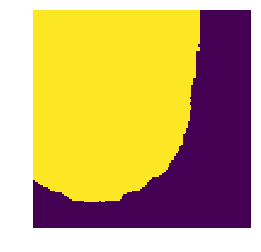

In [166]:
show_img(probs[idx]>0.5);

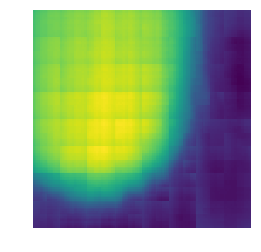

In [167]:
show_img(probs[idx]);

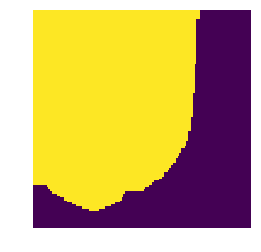

In [168]:
show_img(y[idx]);

# Optimise threshold

In [227]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])
resizeY = np.array([resize_img(x) for x in y])

In [228]:
train_df.columns

Index(['z', 'depth_bin', 'masks', 'coverage', 'coverage_class', 'strat',
       'resizePreds', 'resizeY'],
      dtype='object')

In [229]:
pred_df = pd.DataFrame(index = train_df.index[idxs[1]])
pred_df['depth_bin'] = train_df['depth_bin'].iloc[idxs[1]].values
pred_df['masks'] = train_df['masks'].iloc[idxs[1]].values

In [230]:
train_df.index

Index(['d2b40a2781', '89dba191b1', 'e6ac2a35cd', '236a5cc090', 'f30e47cb36',
       'e0bde1cf11', 'ad16edc8be', 'fa92bed2b1', '6d46f994ac', 'eabed5b2b4',
       ...
       '4b873df7a2', 'cfe4dd9f7e', '500683ce7e', '3f76f25042', 'a00d2b180c',
       'c47c5ea1c3', 'b9c2f9550a', '728890d8f8', 'c38e2a42e3', '942d3bfbf3'],
      dtype='object', name='id', length=4000)

In [231]:
pred_df.head(), val_y[0]

(            depth_bin                                              masks
 id                                                                      
 52914952d6          2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 b93d143e4b          0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 48bb098115          3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 b0d8f26ad8          3  [[257.0, 257.0, 257.0, 257.0, 257.0, 257.0, 25...
 4ff5c5ef47          2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...,
 '/home/giles/Downloads/fastai_data/salt/train_masks-128/d2b40a2781.png')

In [232]:
pred_df = pred_df.reindex([x[x.rfind('/')+1:x.rfind('.')] for x in val_y])

In [233]:
len(val_y), len(idxs[1])

(800, 800)

In [234]:
pred_df.head()

,depth_bin,masks
id,,
d2b40a2781,2,"[[257.0, 257.0, 257.0, 257.0, 257.0, 257.0, 25..."
e6ac2a35cd,2,"[[257.0, 257.0, 257.0, 257.0, 257.0, 257.0, 25..."
e0bde1cf11,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
b5893fc541,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2fe0292eea,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [241]:
pred_df.shape, type(resizePreds)

((800, 2), numpy.ndarray)

In [243]:
pred_df['resizePreds'] = [x for x in resizePreds]
pred_df['resizeY'] = [x for x in resizeY]

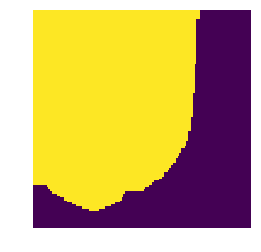

In [245]:
show_img(pred_df['masks'][idx]);

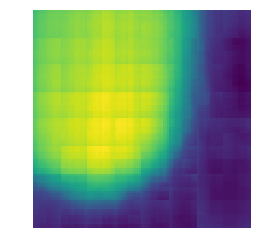

In [246]:
show_img(resizePreds[idx]);

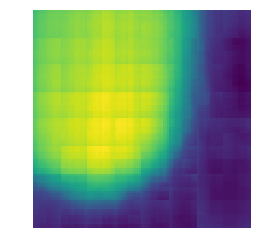

In [247]:
show_img(pred_df['resizePreds'][idx]);

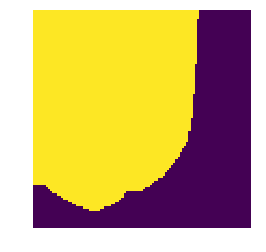

In [248]:
show_img(resizeY[idx]);

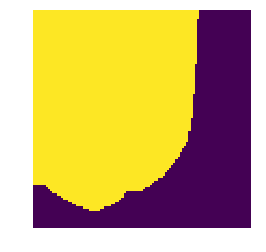

In [249]:
show_img(pred_df['resizeY'][idx]);

In [250]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [266]:
np.array([x for x in pred_df.loc[cut, 'resizePreds'].values]) > 0

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

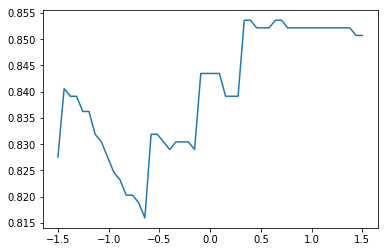

0.33673469387755106 0.8536231884057971


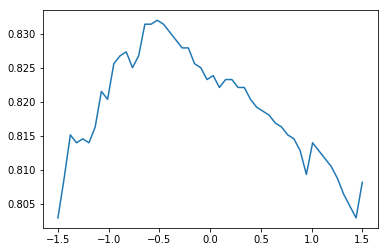

-0.5204081632653061 0.8319767441860465


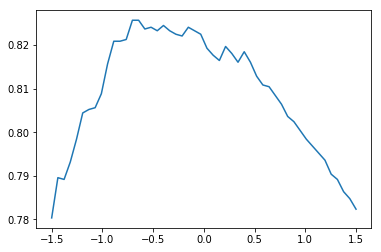

-0.7040816326530612 0.82570281124498


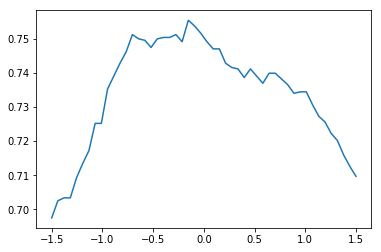

-0.15306122448979598 0.7554621848739497


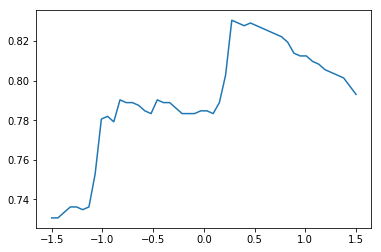

0.2755102040816326 0.8305555555555555


In [268]:
thresholds = {}
for depth in set(pred_df.depth_bin):
    thres = np.linspace(-1.5, 1.5, 50)
    cut = (pred_df.depth_bin == depth)
    thres_ioc = [iou_metric_batch(pred_df.loc[cut, 'resizeY'].values,
                                  np.int32(np.array([x for x in pred_df.loc[cut, 'resizePreds'].values]) > t)) for t in tqdm_notebook(thres)]
    plt.plot(thres, thres_ioc)
    plt.show()
    best_thres = thres[np.argmax(thres_ioc)]
    print(best_thres, max(thres_ioc))
    thresholds[depth] = best_thres

In [269]:
thresholds

{0: 0.33673469387755106,
 1: -0.5204081632653061,
 2: -0.7040816326530612,
 3: -0.15306122448979598,
 4: 0.2755102040816326}

# Run on test

In [285]:
sz=128
bs=64

In [286]:
(PATH/'test-128').mkdir(exist_ok=True)

In [287]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [288]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [289]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [290]:
tfms=tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [291]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [292]:
probs, y = predict(md, nSplits, models, (len(testData), sz, sz), test=True)

In [294]:
test_df = test_df.reindex([x[x.rfind('/')+1:x.rfind('.')] for x in testData])

In [296]:
testData[0]

'/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png'

In [295]:
test_df.head()

,z
id,
ac26efe98e,648
0a5eac8775,355
bdb1c1fcbf,370
5358961921,104
b7b72a69d1,589


In [297]:
test_df['depth_bin'] = 0
for d in range(1,5):
    test_df.loc[test_df.z >= 200*d, 'depth_bin'] = d

In [298]:
test_df.head()

,z,depth_bin
id,,
ac26efe98e,648,3
0a5eac8775,355,1
bdb1c1fcbf,370,1
5358961921,104,0
b7b72a69d1,589,2


In [299]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [301]:
resizePreds.shape

(18000, 101, 101)

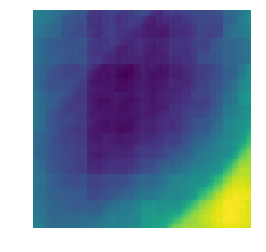

In [300]:
show_img(resizePreds[6]);

In [302]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [303]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [305]:
test_ids = next(os.walk(f'{PATH}/test'))[2]
test_ids[0]

'ac26efe98e.png'

In [310]:
test_df['depth_bin'][6]

1

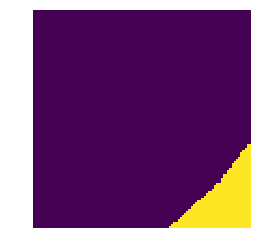

In [311]:
show_img(resizePreds[6] > thresholds[test_df['depth_bin'][6]])

In [312]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [313]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > thresholds[test_df['depth_bin'][i]])) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [314]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [315]:
sub

,rle_mask
id,
ac26efe98e,1 43 102 43 203 43 304 43 405 42 506 41 607 39...
0a5eac8775,
bdb1c1fcbf,
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,6464 1 6564 2 6664 3 6765 3 6865 4 6965 5 7065...
696d91b37e,
73053e4d03,203 2 304 3 308 2 405 6 506 6 607 13 708 14 80...
